# Goal: Jailbreaking Deep Models

In this project, we develop different types of attacks and apply them to a portion of the ImageNet-1K dataset. The ImageNet-1K has 1000 different classes with several images for each class. An example class is guitar. By making many versions of the provided dataset and applying different attacking methods, the weaknesses of deep learning models are explored and understood.

This project does not have a Kaggle competition since it is the last project of the semester for the Deep Learning class at Tandon.

# Task 1: Basics

The pretrained Resnet-34 model and provided ImageNet-1K dataset is loaded to the notebook. The data is processed. The model is evaluated with the original dataset.

**Importing packages**
These packages are needed to start processing the data

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from datasets import load_dataset, Dataset, ClassLabel
import pickle
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Users\nehag\anaconda3\envs\Cuda_test2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Transformations were applied to the dataset to normalize the images. The dataset path also leads to my documents folder. The dataset and dataloader are created.

In [2]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms,
    std=std_norms)
])
dataset_path = "C:\\Users\\nehag\\Documents\\TestDataSet\\TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)


Essential step for processing the data. After examining the Json, I realized that the labels are from 401 to 500. They are identical to the indices already provded by the ImageFolder except they are a difference of 401. Therefore, I added 401 to each index to ensure easier classification with the model.

In [3]:
dataset.samples = [ (path, old_label + 401) for (path, old_label) in dataset.samples ]
dataset.targets = [ old_label + 401 for old_label in dataset.targets ]

Testing to see if the above operation worked for an example case.

In [4]:
img, label = dataset[0]
label

401

How to extract the folder name where the image is located. Not needed.

In [5]:
class_name = dataset.classes[1]
class_name

'n02676566'

Took a labels json from the internet so that I can consistently print all the different labels. Organized json content to a dictionary to easily pass on to functions (for printing labels to graphs and other results)

In [6]:
import json

# Load the class index JSON
with open("C:\\Users\\nehag\\Documents\\TestDataSet\\TestDataSet\\imagenet-simple-labels.json", "r") as f:
    class_names = json.load(f)


# Create a dictionary where the index corresponds to the class name
class_index_to_name = {idx: name for idx, name in enumerate(class_names)}

# Test by printing some class labels
for idx in range(10): 
    print(f"Class index {idx}: {class_index_to_name[idx]}")


Class index 0: tench
Class index 1: goldfish
Class index 2: great white shark
Class index 3: tiger shark
Class index 4: hammerhead shark
Class index 5: electric ray
Class index 6: stingray
Class index 7: cock
Class index 8: hen
Class index 9: ostrich


**Loading the model**


In [7]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Created the evaluate_set function so that a model, dataset and its respective dataloader is fed as parameters. The top5 and top1 accuracies are calculated and printed. This function is handy since the top1 and top5 accuracies need to be found for many different attacks and when using a different model at the end of the program.

In [8]:
def evaluate_set(model, dataset, dataloader):
    model.eval() #switch model to evaluate mode
    model = model.to(device) #move model to gpu
    top1_correct = 0 # constant for counting correct predictions for top1
    total = 0 # total cases with correct and incorrect predictions
    top5_correct = 0 # constant for counting correct predictions for top5
    with torch.no_grad(): #turn off gradients since evaluating
        for images, labels in dataloader: #for each batch in data set (32)
            images = images.to(device) #move images to gpu
            labels = labels.to(device) #move labels to gpu
    
            outputs = model(images) #pass images through model
            top5 = torch.topk(outputs, k=5, dim=1) #compute top5 predictions
            top5_preds = top5.indices #specifically outline the labels
    
            top5_correct += sum([labels[i].item() in top5_preds[i] for i in range(labels.size(0))]) #return true
            # if label matches a prediction for the top 5 return true = 1
            _, predicted = torch.max(outputs, 1) # find prediction for top1
            top1_correct += (predicted == labels).sum().item() # correct predictions in each batch
            total += labels.size(0) # add total amount of images each time for accuracy calculation
    
    accuracy = 100 * top1_correct / total
    top5_accuracy = 100 * top5_correct/ total
    print(f'TOP-1 Accuracy: {accuracy:.2f}%')
    print(f'TOP-5 Accuracy: {top5_accuracy:.2f}%')

The accuracies are already very high! Top-5 is close to 100%. These results suggest that the pretrained model is very good at recognizing the images.

In [9]:
evaluate_set(model, dataset, dataloader)

TOP-1 Accuracy: 76.00%
TOP-5 Accuracy: 94.20%


# Task 2: Pixel-Wise Attacks
Fast Gradient Sign Method (FGSM) is implemented. This method implements a single step of gradient descent in the pixel space and truncates values of the gradients by epsilon. The raw epsilon value cannot exceed 0.02. This means that each pixel can change their value by at most +1/-1. A copy of the original dataset is made. FGSM is applied to the new dataset which is labeled Adversarial Test Set 1. 

**Making adversarial test set 1**: This cell makes a list of the images to be made. Each original image is then cloned and applied PGD. The result is then added to the list. Afterwards, the list is converted to a tensor and then the dataset and loader are created. 

In [10]:
import torch
import torch.nn.functional as F

# Per-channel epsilon (scaled for normalized ImageNet images)
epsilon = torch.tensor([0.0873, 0.0893, 0.0889]).view(3, 1, 1).to(device)

adversarial_images = [] #form of a list, not a tensor

model.eval() #ensure model is in evaluation mode

all_top5_preds_set1 = [] #store predictions and confidences

start_time_task2 = time.time()

for images, labels in dataloader: #for each image and label (as a batch of 32)
    images = images.to(device)
    labels = labels.to(device)

    # Enable gradient wrt input
    images_adv = images.clone().detach().requires_grad_(True)

    # Forward pass
    outputs = model(images_adv)
    loss = F.cross_entropy(outputs, labels)

    # Backward pass: gradient wrt input image
    model.zero_grad()
    loss.backward()

    # Sign of gradient
    grad_sign = images_adv.grad.sign()

    # FGSM attack
    perturbed = images_adv + epsilon * grad_sign

    # Clamp to valid normalized range ([-3, 3] safe for ImageNet)
    perturbed = torch.clamp(perturbed, -3, 3)

    # Save perturbed image (copy)
    adversarial_images.append(perturbed.detach())

    # Save top-5 predictions with confidences
    final_outputs = model(perturbed)
    probs = F.softmax(final_outputs, dim=1)
    top5_probs, top5_indices = probs.topk(5, dim=1)

    for i in range(images.size(0)):
        top5 = [(top5_indices[i, j].item(), top5_probs[i, j].item()) for j in range(5)]
        all_top5_preds_set1.append(top5)

end_time_task2 = time.time()

In [54]:
print(f"Time taken for task 2: {(end_time_task2 - start_time_task2)} seconds.")

Time taken for task 2: 11.419596433639526 seconds.


Extract all the labels from the original dataset.  Convert the images that are in a list to a tensor. Convert the labels which are in a list to a tensor. Then connect the label and image tensor together with Tensor Dataset. Then make the data loader with that Tensor Dataset.

In [12]:
from torch.utils.data import TensorDataset, DataLoader
adv_images_tensor = torch.cat(adversarial_images, dim=0)
#extract all the labels from the original dataset so that they can be added to the new cloned attacked sets
all_labels = []
for _, labels in dataloader:
    all_labels.append(labels)
all_labels = torch.cat(all_labels, dim=0)

# Now make a dataset
adversarial_test_set1 = TensorDataset(adv_images_tensor, all_labels)

# Wrap into a DataLoader
adversarial_loader1 = DataLoader(adversarial_test_set1, batch_size=32, shuffle=False)

In order to plot the images, the images need to be unnormalized. This unnormalize function takes a tensor, the std and mean value specified in the beginning of the program and then clips the image to display it properly. The image is then returned. This function is normally used within other functions to print an image with matplotlib.

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Unnormalize and convert to numpy
def unnormalize(img_tensor, mean, std):
    img = img_tensor.cpu().clone()  # clone to avoid modifying original
    img = img.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]
    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clamp to [0, 1] for display
    return img

This is the function that takes in the original image of the dataset and the new attacked image, printing them both out side by side for comparision. 

In [14]:
# Unnormalize both
import matplotlib.pyplot as plt

def display_og_adv(dataset, adversarial_dataset, n, mean_norms, std_norms, top5_preds, class_names=None):
    image, label = dataset[n]
    perturbed, _ = adversarial_dataset[n]
    img_orig = unnormalize(image, mean_norms, std_norms)
    img_adv  = unnormalize(perturbed, mean_norms, std_norms)
    
    # Get top-5 predictions for this image
    top5 = top5_preds[n]
    class_labels = [class_names[idx] if class_names else f"Class {idx}" for idx, _ in top5]
    confidences = [conf for _, conf in top5]

    # Plot: original, adversarial, and bar plot
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img_orig)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Adversarial Image")
    plt.imshow(img_adv)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.barh(range(5), list(reversed(confidences)), color='skyblue')
    plt.yticks(range(5), list(reversed(class_labels)))
    plt.xlabel("Confidence")
    plt.title("Top-5 Predictions")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

For this task, each of the accuracies had to be less than 30% which is achieved. Evaluate_set function evaluated the new pixel attacked dataset with the pretrained resnet-34 model.

In [15]:
evaluate_set(model, adversarial_test_set1, adversarial_loader1)

TOP-1 Accuracy: 3.80%
TOP-5 Accuracy: 21.40%


Sometimes, we want to only find the prediction for a single image. This function makes that happen by setting the image to evaluation mode; making sure the model is set to GPU; and then predicting the label with the model from the parameter. The predicted and actual label is printed.

In [16]:
def evaluate_single_image(model, image, label, class_index_to_name):
    model.eval()  # switch model to evaluation mode
    model = model.to(device)  # move model to gpu

    # Add a batch dimension to the single image tensor (since model expects batches)
    image = image.unsqueeze(0).to(device)  # shape [1, C, H, W]

    with torch.no_grad():  # turn off gradients since evaluating
        outputs = model(image)  # pass image through model
        _, predicted = torch.max(outputs, 1)  # find prediction for top1

    # Print the predicted label and the actual label
    predicted_label = int(predicted)
    actual_label = int(label)
    

    print(f"Predicted Label: {class_index_to_name[predicted_label]}, Actual Label: {class_index_to_name[actual_label]}")

In order to find meaningful cases where the predicted labels for the adversarial testset differ from the original dataset, the first 10 images and their predictions are printed. We can see that sometimes the prediction differs from the actual label; however, if the model misclassified the image with the original dataset, I ignored that result and tried to find where the predicted labels differed. I specifically tried to find casess where the original image was correctly classified while the attacked image was misclassified. Selected image 1, 3, and 6

In [17]:
for n in range(0, 10):
    print(f"For {n}th image in set: ")
    test_image, test_label = adversarial_test_set1[n]
    og_image, og_label = dataset[n]
    evaluate_single_image(model, og_image, og_label, class_index_to_name)
    evaluate_single_image(model, test_image, test_label, class_index_to_name)
    print("------------------------")


For 0th image in set: 
Predicted Label: accordion, Actual Label: accordion
Predicted Label: accordion, Actual Label: accordion
------------------------
For 1th image in set: 
Predicted Label: accordion, Actual Label: accordion
Predicted Label: radiator, Actual Label: accordion
------------------------
For 2th image in set: 
Predicted Label: stage, Actual Label: accordion
Predicted Label: stage, Actual Label: accordion
------------------------
For 3th image in set: 
Predicted Label: accordion, Actual Label: accordion
Predicted Label: safety pin, Actual Label: accordion
------------------------
For 4th image in set: 
Predicted Label: abacus, Actual Label: accordion
Predicted Label: abacus, Actual Label: accordion
------------------------
For 5th image in set: 
Predicted Label: electric guitar, Actual Label: acoustic guitar
Predicted Label: electric guitar, Actual Label: acoustic guitar
------------------------
For 6th image in set: 
Predicted Label: acoustic guitar, Actual Label: acousti

For the following example images, it is hard to find the differences between the original and adversarial case even by zooming in. This suggests that even slightly affecting the pixels can change the overall pattern of the image the model was designed to find.

In [18]:
test_image, test_label = adversarial_test_set1[1]
og_image, og_label = dataset[1]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: accordion, Actual Label: accordion
Predicted Label: radiator, Actual Label: accordion


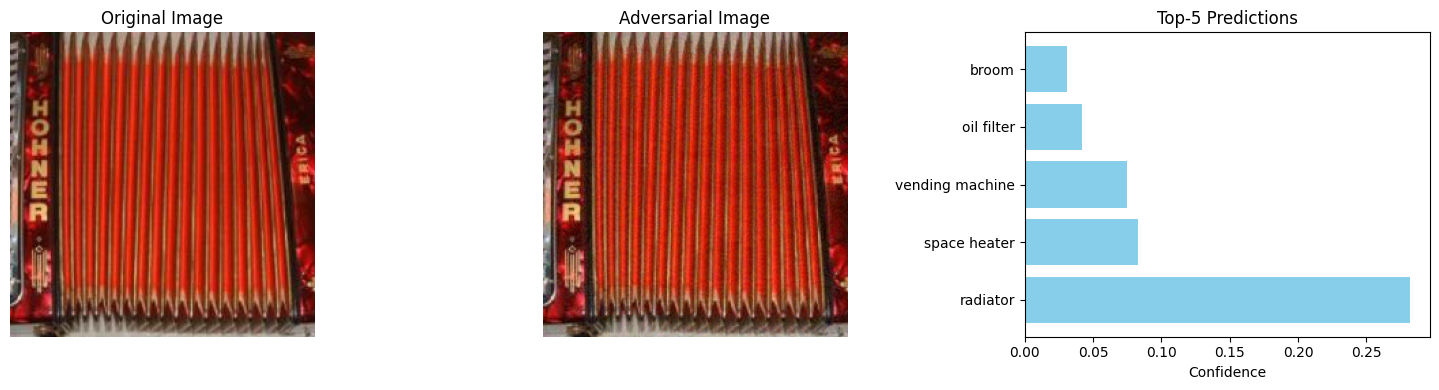

In [19]:
display_og_adv(dataset, adversarial_test_set1, 1, mean_norms, std_norms, all_top5_preds_set1, class_index_to_name)

In [20]:
test_image, test_label = adversarial_test_set1[3]
og_image, og_label = dataset[3]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: accordion, Actual Label: accordion
Predicted Label: safety pin, Actual Label: accordion


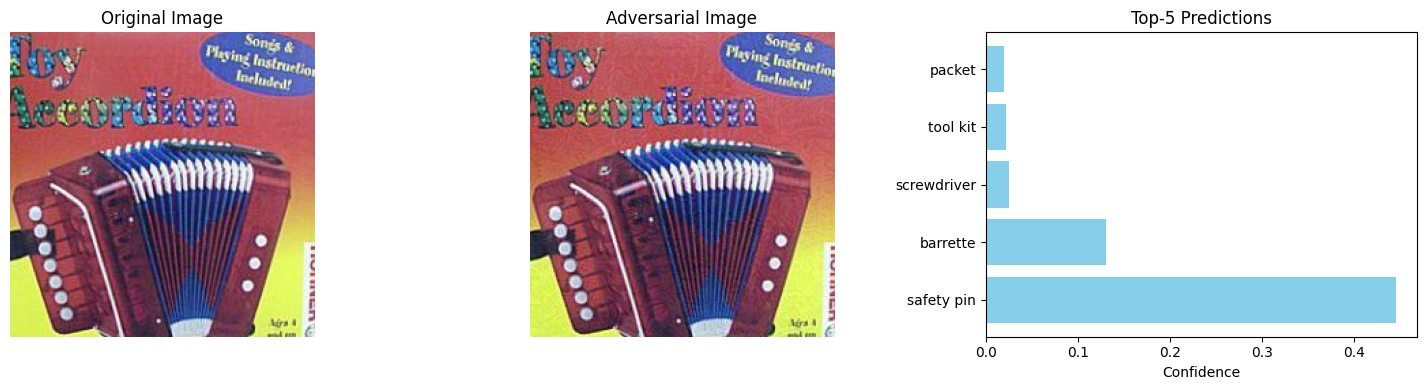

In [21]:
display_og_adv(dataset, adversarial_test_set1, 3, mean_norms, std_norms, all_top5_preds_set1, class_index_to_name)

In [22]:
test_image, test_label = adversarial_test_set1[6]
og_image, og_label = dataset[6]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: acoustic guitar, Actual Label: acoustic guitar
Predicted Label: face powder, Actual Label: acoustic guitar


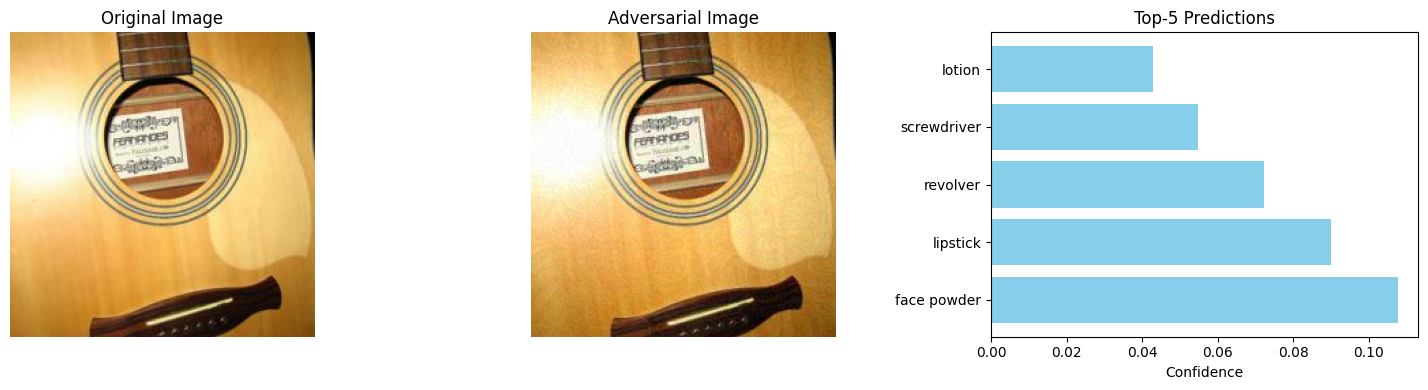

In [23]:
display_og_adv(dataset, adversarial_test_set1, 6, mean_norms, std_norms, all_top5_preds_set1, class_index_to_name)

# Task 3: Improved Attacks
After applying a pixel-wise attack in the previous task, another attack was implemented to a fresh clone of the original dataset. This attack is known as Progressive Gradient Descent (PGD) where contraints are taken into account while updating the gradients. The top1 and top5 accuracies must be 70% lower than those of the original dataset.

The following cell holds the pdg_attack_loader function. The dataloader loads the images and labels so that the gradients can be computed. The gradients are adjusted with respect to alpha and epsilon. The final results are applied to each image and returned at the end of the function. 

The epsilon values were found by dividing the raw epsilon by the original std values. The raw epsilon is 0.02. Thus, 0.02/original std = 0.0873 for example. 

In [24]:
epsilon_norm = torch.tensor([0.0873, 0.0893, 0.0889]).view(3,1,1).to(device)  # normalized epsilon
alpha = epsilon / 9
num_iter = 2

all_top5_preds_set2 = []
def pgd_attack_loader(model, dataloader, epsilon, alpha, num_iter, all_top5_preds_set2):
    model.eval()  # set to eval mode
    adv_images_list = []
    labels_list = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Initialize adv_images as clean image
        adv_images = images.clone().detach()
        # for each image
        for i in range(num_iter):
            adv_images.requires_grad = True
            outputs = model(adv_images) #find the prediction for that image

            loss = F.cross_entropy(outputs, labels) #compute the loss
            model.zero_grad()
            loss.backward() #backpropogate

            # Gradient sign step
            grad_sign = adv_images.grad.sign()
            adv_images = adv_images + alpha * grad_sign #essential step for PGD, apply pgd

            # Projection: clamp perturbation within epsilon of original image
            perturbation = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            adv_images = torch.clamp(images + perturbation, min=-3, max=3).detach()  # normalized clamp
        #add images to the list and labels
        adv_images_list.append(adv_images)
        labels_list.append(labels)
        # Save top-5 predictions with confidences
        final_outputs = model(adv_images)
        probs = F.softmax(final_outputs, dim=1)
        top5_probs, top5_indices = probs.topk(5, dim=1)
    
        for i in range(images.size(0)):
            top5 = [(top5_indices[i, j].item(), top5_probs[i, j].item()) for j in range(5)]
            all_top5_preds_set2.append(top5)

    # Stack into tensors
    adv_images_tensor = torch.cat(adv_images_list, dim=0)
    labels_tensor = torch.cat(labels_list, dim=0)

    return adv_images_tensor, labels_tensor

After defining the function, the function is used to make the new images and label tensors.|

In [25]:
start_time_task3 = time.time()
adv_set2_images_tensor, adv_set2_labels_tensor = pgd_attack_loader(model, 
                                                                   dataloader, 
                                                                   epsilon_norm, 
                                                                   alpha, 
                                                                   num_iter,
                                                                   all_top5_preds_set2)
end_time_task3 = time.time()

In [55]:
print(f"Time taken for task 3: {(end_time_task3 - start_time_task3)} seconds.")

Time taken for task 3: 11.114131689071655 seconds.


Joining the image and label tensors to make a dataset. Using that dataset to make a dataloader.

In [27]:
# Now make a dataset
adversarial_test_set2 = TensorDataset(adv_set2_images_tensor, all_labels)

# Wrap into a DataLoader
adversarial_loader2 = DataLoader(adversarial_test_set2, batch_size=32, shuffle=False)

The results were supposed to be atleast 70% less than those of the original dataset. This goal has been achieved. The accuracy for top1 is close to zero; however, the top5 accuracy is significantly higher. This suggests that the attack is not super strong but still prevents the first guess from being correct.

In [28]:
evaluate_set(model, adversarial_test_set2, adversarial_loader2)

TOP-1 Accuracy: 1.20%
TOP-5 Accuracy: 21.40%


**Verification that the new images are similar to the original images as requested.**

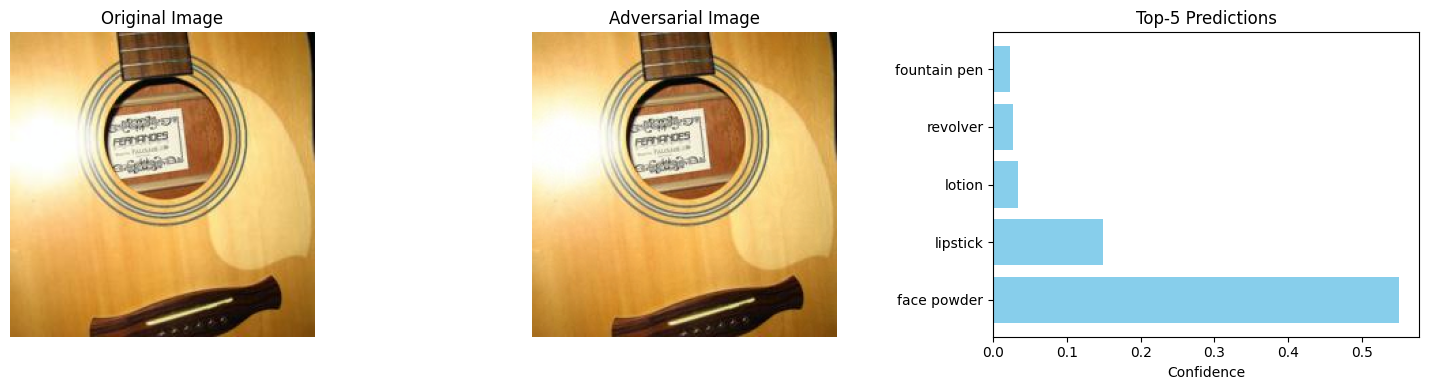

In [29]:
display_og_adv(dataset, adversarial_test_set2, 6, mean_norms, std_norms, all_top5_preds_set2, class_index_to_name)

**The three example images:** The adversarial image again does not appear to be very different from the original. However, each case's prediction is not accurate to the ground truth. Additionally, the results for the misclassifications appear to match to those of the pixel attacked images.

In [30]:
test_image, test_label = adversarial_test_set2[1]
og_image, og_label = dataset[1]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: accordion, Actual Label: accordion
Predicted Label: radiator, Actual Label: accordion


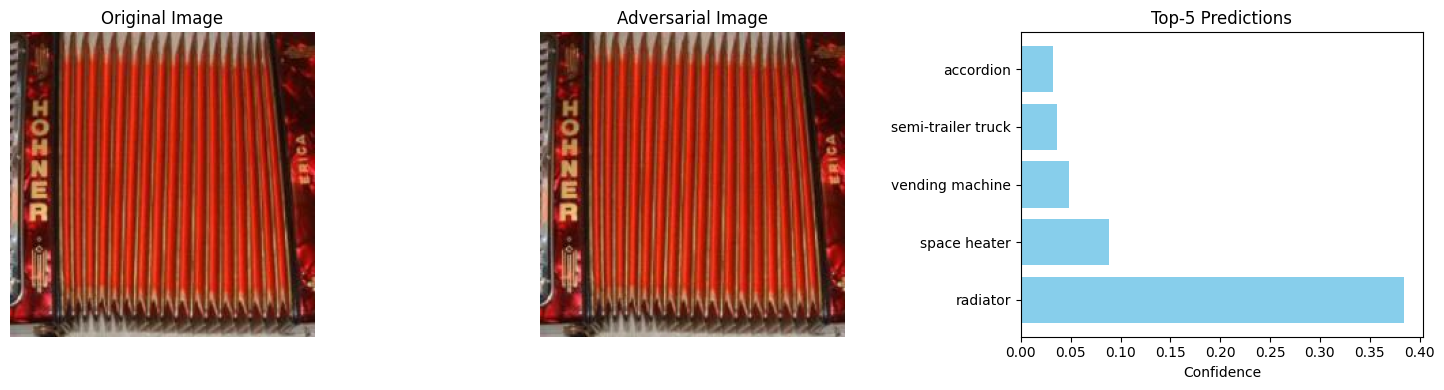

In [31]:
display_og_adv(dataset, adversarial_test_set2, 1, mean_norms, std_norms, all_top5_preds_set2, class_index_to_name)

In [32]:
test_image, test_label = adversarial_test_set2[3]
og_image, og_label = dataset[3]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: accordion, Actual Label: accordion
Predicted Label: safety pin, Actual Label: accordion


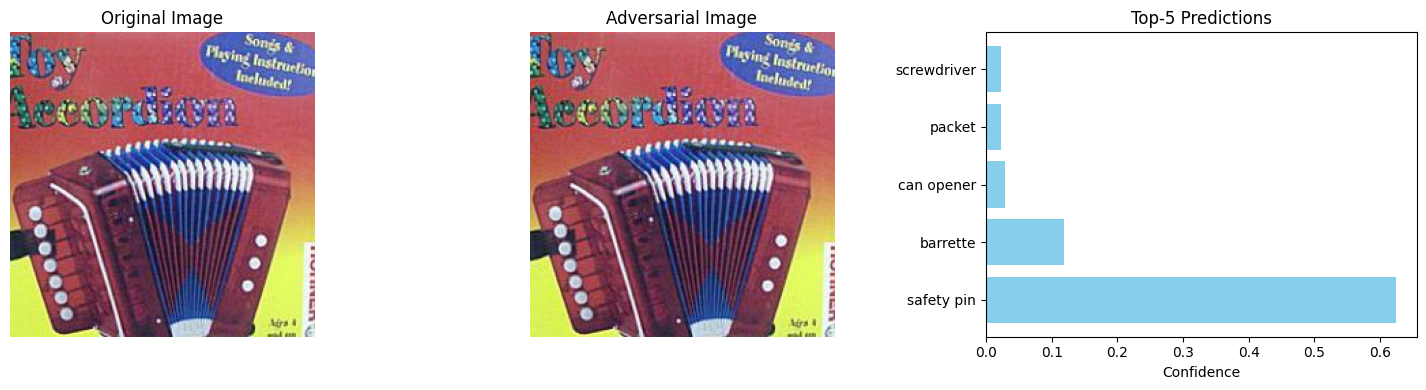

In [33]:
display_og_adv(dataset, adversarial_test_set2, 3, mean_norms, std_norms, all_top5_preds_set2, class_index_to_name)

In [34]:
test_image, test_label = adversarial_test_set2[6]
og_image, og_label = dataset[6]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: acoustic guitar, Actual Label: acoustic guitar
Predicted Label: face powder, Actual Label: acoustic guitar


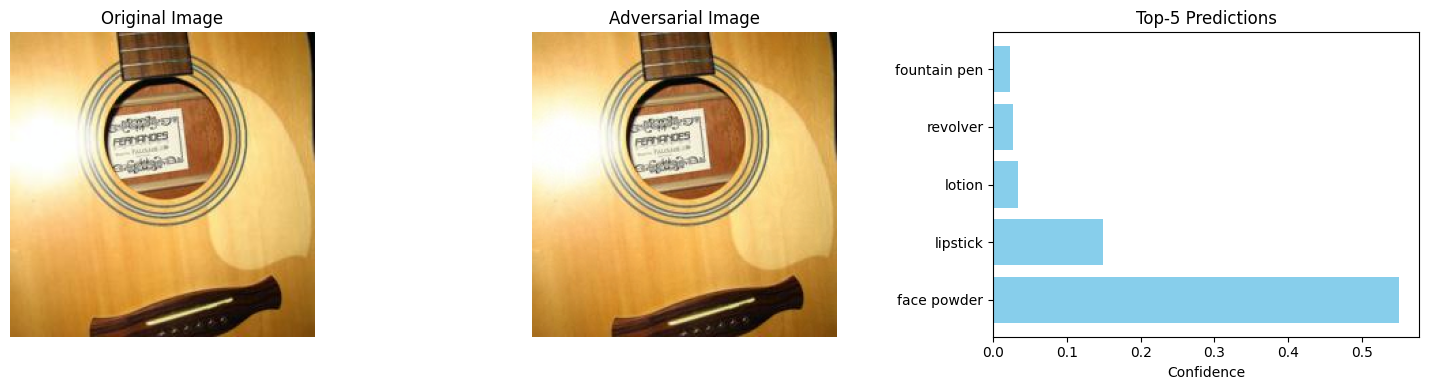

In [35]:
display_og_adv(dataset, adversarial_test_set2, 6, mean_norms, std_norms, all_top5_preds_set2, class_index_to_name)

# Task 4: Patch Attacks
This time, an attack is not applied to the entire image. It must cover only 32x32. This is challenging because 32x32 is only around 10% of the image, and yet, it is supposed to trick the model into predicting incorrectly. Targetted attacks were used by training the patch. The patch would then trick the model into classifying the images as class 859. This trend is observed for the first and second example image where the predicted classes are 859. A new dataset was created labeled Adversarial Test Set 3 which hosts a copy of the patch on each image. 


The following cell uses regular gradient descent to train a 32 by 32 patch with the original dataset. The patch is placed in the center and trained to exploit the weaknesses of the mode. The target_class variable will ensure that the model appears to be of that class (859).

In [36]:
import random
import torch
import torch.nn.functional as F

# Settings
patch_size = 32
num_epochs = 300 # Can be just 270 since the results appear to plateau after that
target_class = 859 
alpha = 0.1  # learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize patch
patch = torch.randn(3, patch_size, patch_size, device=device, requires_grad=True)

optimizer = torch.optim.Adam([patch], lr=alpha)

# Ensure model is in evaluation mode
model.eval()

# For clamping
image_min = -3
image_max = 3

start_time_task4 = time.time()

for epoch in range(num_epochs):
    for images, _ in dataloader:
        images = images.to(device)
        B, C, H, W = images.shape

        # Randomly select placement location for each image
        x_start = (W - patch_size) // 2  # OR random.randint(0, W - patch_size)
        y_start = (H - patch_size) // 2  # OR random.randint(0, H - patch_size)

        # Clone images and paste patch
        patched_images = images.clone()
        patched_images[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size] = patch.unsqueeze(0)

        # Forward pass
        outputs = model(patched_images)

        # Targeted loss (we want outputs to predict target_class)
        target_labels = torch.full((B,), target_class, dtype=torch.long, device=device)
        loss = F.cross_entropy(outputs, target_labels)

        # Backprop and optimize patch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Clip patch pixel values
        patch.data.clamp_(min=image_min, max=image_max)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

# Now patch is optimized!
torch.save(patch.detach().cpu(), "optimized_patch.pt")

end_time_task4 = time.time()

Epoch 0/300, Loss: 12.5819
Epoch 5/300, Loss: 3.5610
Epoch 10/300, Loss: 2.0428
Epoch 15/300, Loss: 1.3406
Epoch 20/300, Loss: 0.9030
Epoch 25/300, Loss: 0.6956
Epoch 30/300, Loss: 0.6050
Epoch 35/300, Loss: 0.5395
Epoch 40/300, Loss: 0.5051
Epoch 45/300, Loss: 0.4870
Epoch 50/300, Loss: 0.4766
Epoch 55/300, Loss: 0.4666
Epoch 60/300, Loss: 0.4537
Epoch 65/300, Loss: 0.4411
Epoch 70/300, Loss: 0.4357
Epoch 75/300, Loss: 0.4322
Epoch 80/300, Loss: 0.4255
Epoch 85/300, Loss: 0.4210
Epoch 90/300, Loss: 0.4137
Epoch 95/300, Loss: 0.4100
Epoch 100/300, Loss: 0.4057
Epoch 105/300, Loss: 0.4032
Epoch 110/300, Loss: 0.4001
Epoch 115/300, Loss: 0.3937
Epoch 120/300, Loss: 0.3880
Epoch 125/300, Loss: 0.3876
Epoch 130/300, Loss: 0.3866
Epoch 135/300, Loss: 0.3851
Epoch 140/300, Loss: 0.3829
Epoch 145/300, Loss: 0.3788
Epoch 150/300, Loss: 0.3799
Epoch 155/300, Loss: 0.3810
Epoch 160/300, Loss: 0.3805
Epoch 165/300, Loss: 0.3799
Epoch 170/300, Loss: 0.3790
Epoch 175/300, Loss: 0.3808
Epoch 180/300

In [53]:
print(f"Time taken for task 4: {(end_time_task4 - start_time_task4)/60} minutes.")

Time taken for task 4: 35.622312394777936 minutes.


Save the patch so that it can be applied to each image later.

In [38]:
# After training, save the optimized patch
torch.save(patch.detach().cpu(), "optimized_patch.pt")

# 2. Apply the optimized patch to all images in the dataset
patch = torch.load("optimized_patch.pt").to(device)

Apply the patch to each image.

In [39]:
all_patched_images = []
all_patched_labels = []
all_top5_preds_set3 = []

# Assuming you want to apply the patch to the entire dataset
for images, labels in dataloader:
    images = images.to(device)
    B, C, H, W = images.shape

    # Ensure patch stays in the same place
    x_start = (W - patch_size) // 2 
    y_start = (H - patch_size) // 2  

    # Clone images and paste patch
    patched_images = images.clone()
    patched_images[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size] = patch.unsqueeze(0)

    all_patched_images.append(patched_images)
    #all_patched_labels.append(labels)

     # Get model outputs
    with torch.no_grad():
        outputs = model(patched_images)
        probs = F.softmax(outputs, dim=1)
        top5_probs, top5_indices = probs.topk(5, dim=1)

    # Store top-5 predictions for each image
    for i in range(images.size(0)):
        top5 = [(top5_indices[i, j].item(), top5_probs[i, j].item()) for j in range(5)]
        all_top5_preds_set3.append(top5)
    

# Convert to a single tensor for easy saving
all_patched_images = torch.cat(all_patched_images, dim=0)
#all_labels = torch.cat(all_labels, dim=0)

Convert the image and label tensor to dataset and make the dataloader as well.

In [40]:
# Now make a dataset
adversarial_test_set3 = TensorDataset(all_patched_images, all_labels)
# Wrap into a DataLoader
adversarial_loader3 = DataLoader(adversarial_test_set3, batch_size=32, shuffle=False)

TOP1 is less than 10%. Had difficulties with making top5 accuracy less than 10%

In [41]:
evaluate_set(model, adversarial_test_set3, adversarial_loader3)

TOP-1 Accuracy: 11.00%
TOP-5 Accuracy: 29.80%


The final three test cases. The patch is very visible and appears to be a distorted twisted mixture of color (kind of like how mixed paint appears on a palette. This effect shows that the patch was trained to trick the model. The other part of the image is unchanged as requested.

In [42]:
m = 6
test_image, test_label = adversarial_test_set3[m]
og_image, og_label = dataset[m]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: acoustic guitar, Actual Label: acoustic guitar
Predicted Label: toaster, Actual Label: acoustic guitar


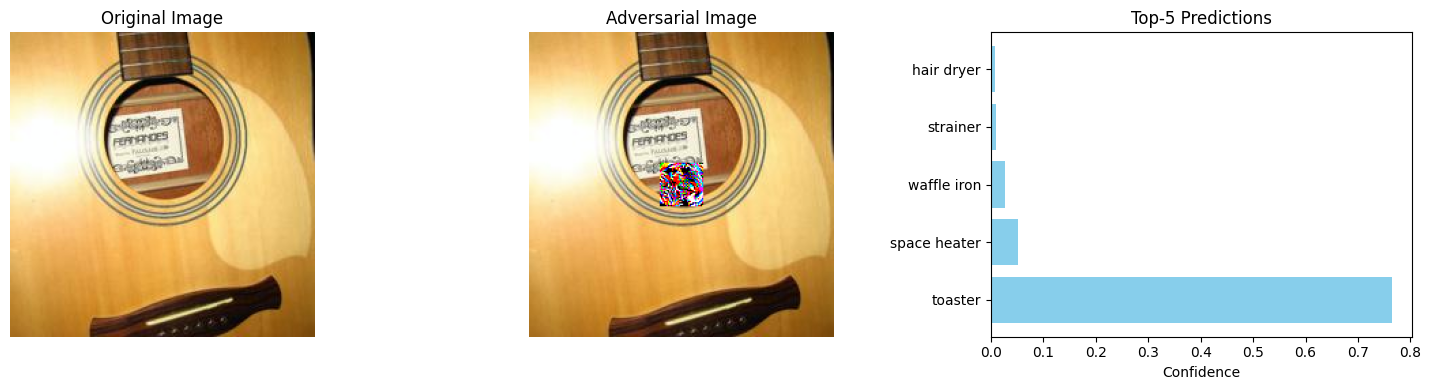

In [43]:
display_og_adv(dataset, adversarial_test_set3, 6, mean_norms, std_norms, all_top5_preds_set3, class_index_to_name)

In [44]:
m = 3
test_image, test_label = adversarial_test_set3[m]
og_image, og_label = dataset[m]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: accordion, Actual Label: accordion
Predicted Label: toaster, Actual Label: accordion


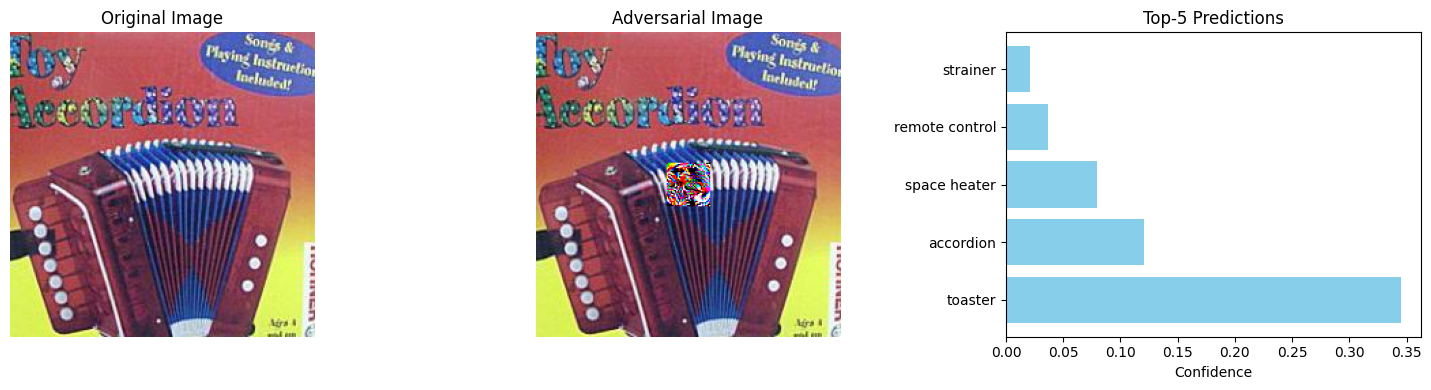

In [45]:
display_og_adv(dataset, adversarial_test_set3, 3, mean_norms, std_norms, all_top5_preds_set3, class_index_to_name)

In [46]:
m = 1
test_image, test_label = adversarial_test_set3[m]
og_image, og_label = dataset[m]
evaluate_single_image(model, og_image, og_label, class_index_to_name)
evaluate_single_image(model, test_image, test_label, class_index_to_name)

Predicted Label: accordion, Actual Label: accordion
Predicted Label: space heater, Actual Label: accordion


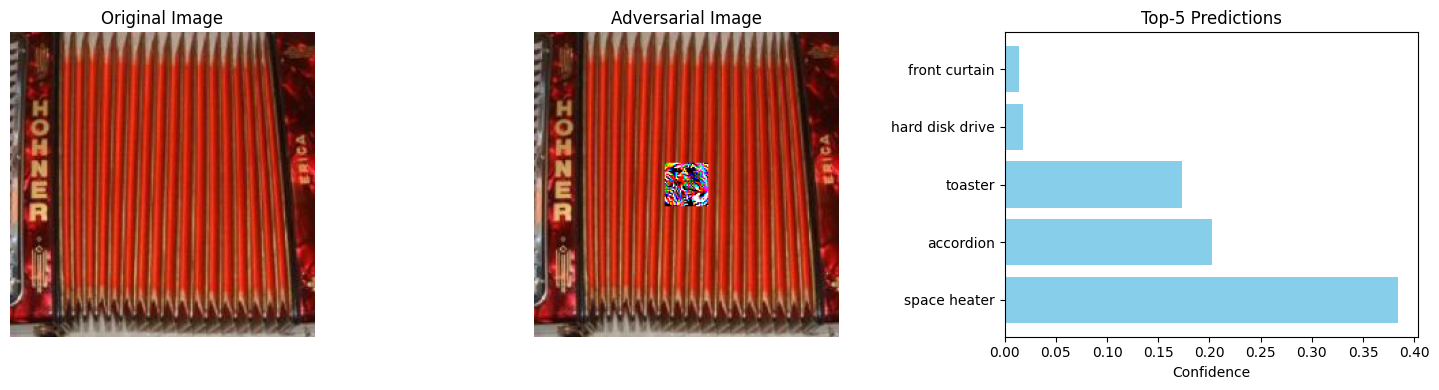

In [47]:
display_og_adv(dataset, adversarial_test_set3, 1, mean_norms, std_norms, all_top5_preds_set3, class_index_to_name)

# Task 5
After finding the top1 and top5 results for each dataset with the resnet34 model, another model known as the densenet121 was evaluated with the same datasets. This excercise was used to demonstrate how the effects of the attacks can transfer from different architectures. The top1 and top5 results are printed for the new model. As observed the original dataset accuracies appear very close to those with the resnet34 model. However, The rest of the accuracies boosted up from their resnet-34 results. This suggests that the densenet121 model possibly prepared for attacks during training.

In [48]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')

In [49]:
evaluate_set(new_model, dataset, dataloader)

TOP-1 Accuracy: 74.60%
TOP-5 Accuracy: 93.60%


In [50]:
evaluate_set(new_model, adversarial_test_set1, adversarial_loader1)

TOP-1 Accuracy: 45.20%
TOP-5 Accuracy: 75.80%


In [51]:
evaluate_set(new_model, adversarial_test_set2, adversarial_loader2)

TOP-1 Accuracy: 63.60%
TOP-5 Accuracy: 89.60%


In [52]:
evaluate_set(new_model, adversarial_test_set3, adversarial_loader3)

TOP-1 Accuracy: 67.60%
TOP-5 Accuracy: 88.00%


**Comments on Findings**

By checking the accuracy of the Densenet model of predicting the labels for the datasets, the top1
and top5 accuracies for all are very cloes to one another. The original dataset has the highest accuracies. 
Surprisingly, the pixelwise attack had the lowest accuracies by around 15-20% compared to adversarial dataset 2 and 3. This shows that pixelwise attacks are very effective despite the effects looking negligible. When I compared the original image to that of the pixel attacked image, they both looked identical. This is because each pixel's values changed and the model was not prepared such random changes to an image. The values possibly felt artificial to the model because the patterns it learned was no longer present, leading to the lower accuracy.

Another finding was that the simple addition of a 32 by 32 noise patch was not an effective attack. This is because the pretrained model was possibly prepared for noisy patches, so it ignored that portion. The random placement also helped keep a high accuracy because the patches were placed in areas that were not important for classification. I eventually came up with the idea to train the patch to target a specific class. However, by adding grad-cam, the accuracies were back to being high. 

 
**Trends Observed**

Task 2 and 3's classifications of the images appeared identical despite misclassifying the image. This suggests that there is a trend where the attacks guide the image to appear to be of a different class when a light attack is placed on the entire image. 


**Lessons Learned**

The lessons I learned are that patch attacks do not have to be simply noise. They can be an imported image, a trained image, or even a pattern (such as checkered). I learned that a patch can be trained and placed in a specific spot to exploit a model's weaknesses. I also learned that a light pixel attack or PGD can make the image appear to be identical to the original and yet significantly affect predicitions.


**Potential Ways Mitigating Transferability**

To prevent attacks from signficantly affecting one model to another with different architectures, adversarial images can be fed to a model to quickly recognize attacks and classify them separately. Adding random transformations can also help models handle attacks. Processing data before transfering them to a model for evaluation can also lessen the attack's effect.